[Kaggle notebook](https://www.kaggle.com/code/pmassouf/hotel-price-prediction/notebook)

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

from sklearn.model_selection import  cross_val_score, train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
import aoai

In [3]:
%config Completer.use_jedi = False

In [4]:
__dataset_object = aoai.Dataset()
__dataset_object.list("Hotel")

C:\Users\91930\Documents\GITHUB\ArtOfAI\dataset\kaggle\hotel_price_prediction\HotelFinalDataset.xlsx


In [5]:
__dataset_path = __dataset_object.get("Hotel")[0]

In [6]:
df = pd.read_excel(__dataset_path, sheet_name="HotelFinalDataset.xlsx")

In [7]:
df.head()

,Unnamed: 0,Name,Place,Type,Price,ReviewsCount,Rating,City,State
0,0,BUNK Hotel Amsterdam,"Amsterdam Noord, Amsterdam",Bunk Pod for 2,"₹ 7,887",778.0,8.4,Amsterdam Noord,Amsterdam
1,1,YOTEL Amsterdam,"Amsterdam Noord, Amsterdam",Premium Double Room,"₹ 15,267",500.0,8.1,Amsterdam Noord,Amsterdam
2,2,Multatuli Hotel,"Amsterdam City Center, Amsterdam",Double Room,"₹ 13,063",1605.0,7.4,Amsterdam City Center,Amsterdam
3,3,nhow Amsterdam Rai,"Zuideramstel, Amsterdam",nhow Double or Twin Room with View,"₹ 12,854",500.0,9.0,Zuideramstel,Amsterdam
4,4,Motel One Amsterdam,"Zuideramstel, Amsterdam",Double Room,"₹ 9,471",500.0,8.8,Zuideramstel,Amsterdam


We can remove the 'first column' as it is the same as the index of the dataset. The 'place' column is also redundant with the City and State columns

In [8]:
df = df.drop(["Unnamed: 0", "Place"], axis=1)

In [9]:
df.head()

,Name,Type,Price,ReviewsCount,Rating,City,State
0,BUNK Hotel Amsterdam,Bunk Pod for 2,"₹ 7,887",778.0,8.4,Amsterdam Noord,Amsterdam
1,YOTEL Amsterdam,Premium Double Room,"₹ 15,267",500.0,8.1,Amsterdam Noord,Amsterdam
2,Multatuli Hotel,Double Room,"₹ 13,063",1605.0,7.4,Amsterdam City Center,Amsterdam
3,nhow Amsterdam Rai,nhow Double or Twin Room with View,"₹ 12,854",500.0,9.0,Zuideramstel,Amsterdam
4,Motel One Amsterdam,Double Room,"₹ 9,471",500.0,8.8,Zuideramstel,Amsterdam


We can see that we don't seem to have many features to work with. We will have to create more.

### Data preparation and Feature Engineering

In [10]:
df.isna().sum()

Name              0
Type              0
Price             0
ReviewsCount     13
Rating           10
City              0
State           392
dtype: int64

There are NaN values in multiple columns. We will remove rows with NaN values in ReviewsCount and Rating. For state we'll use one hot vectors

In [11]:
# creating a dataframe of hotels with 
# `ReviewsCount` and `Rating`


df = df[df['ReviewsCount'].notna() & df['Rating'].notna()]

In [12]:
df.groupby('Type').Name.count()

Type
 Deluxe double or Twin Room                       1
1 Queen or King Bed Essential Room                1
2-person Premium Hotelroom                        1
6 Person Room with Private Bathroom and Shower    1
Apartment                                         2
                                                 ..
Two-Bedroom Chalet                                3
Two-Bedroom House                                 6
Two-Bedroom Suite                                 1
bunk                                              1
nhow Double or Twin Room with View                1
Name: Name, Length: 187, dtype: int64

There are many different types of housing. We'll take into account the words that come up often in the description.

In [13]:
data_set = df['Type'].values

In [14]:
data_set = list(data_set)

In [15]:
data_set = " ".join(data_set)

In [16]:
# Here we'll output the ten most common words in the Type column

from collections import Counter

split_str = data_set.split()

counter = Counter(split_str)

common = counter.most_common(10)

print(common)

[('Room', 356), ('Double', 214), ('Twin', 102), ('with', 85), ('Standard', 79), ('Deluxe', 65), ('Apartment', 50), ('Comfort', 47), ('Bathroom', 35), ('One-Bedroom', 32)]


In [17]:
# We can get a list of columns to add out dataset and make one hot vectors for the types

types = []

for tup in common:
    types.append(tup[0].lower())

In [18]:
print(types)

['room', 'double', 'twin', 'with', 'standard', 'deluxe', 'apartment', 'comfort', 'bathroom', 'one-bedroom']


In [19]:
from sklearn.feature_extraction.text import CountVectorizer

In [20]:
pattern = "(?u)\\b[\\w-]+\\b"

cv = CountVectorizer(vocabulary=types, token_pattern=pattern)

one_hot = pd.DataFrame(cv.fit_transform(df['Type']).todense(), df.index, cv.get_feature_names_out())

In [21]:
one_hot

,room,double,twin,with,standard,deluxe,apartment,comfort,bathroom,one-bedroom
0,0,0,0,0,0,0,0,0,0,0
1,1,1,0,0,0,0,0,0,0,0
2,1,1,0,0,0,0,0,0,0,0
3,1,1,1,1,0,0,0,0,0,0
4,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...
520,0,0,0,0,0,0,1,0,0,0
521,1,1,0,0,1,0,0,0,0,0
522,1,1,0,1,0,0,0,0,1,0
523,1,0,1,0,1,0,0,0,0,0


In [23]:
# we convert data types for the columns
one_hot = one_hot.apply(pd.to_numeric)

In [25]:
df = df.join(one_hot)

In [26]:
df

,Name,Type,Price,ReviewsCount,Rating,City,State,room,double,twin,with,standard,deluxe,apartment,comfort,bathroom,one-bedroom
0,BUNK Hotel Amsterdam,Bunk Pod for 2,"₹ 7,887",778.0,8.4,Amsterdam Noord,Amsterdam,0,0,0,0,0,0,0,0,0,0
1,YOTEL Amsterdam,Premium Double Room,"₹ 15,267",500.0,8.1,Amsterdam Noord,Amsterdam,1,1,0,0,0,0,0,0,0,0
2,Multatuli Hotel,Double Room,"₹ 13,063",1605.0,7.4,Amsterdam City Center,Amsterdam,1,1,0,0,0,0,0,0,0,0
3,nhow Amsterdam Rai,nhow Double or Twin Room with View,"₹ 12,854",500.0,9.0,Zuideramstel,Amsterdam,1,1,1,1,0,0,0,0,0,0
4,Motel One Amsterdam,Double Room,"₹ 9,471",500.0,8.8,Zuideramstel,Amsterdam,1,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,Stadslogement Bij de Sassenpoort,Superior Apartment,"₹ 8,899",232.0,8.4,Zwolle,NaN,0,0,0,0,0,0,1,0,0,0
521,Mercure Hotel Zwolle,Standard Double Room,"₹ 10,205",1402.0,7.7,Zwolle,NaN,1,1,0,0,1,0,0,0,0,0
522,The Cabin at Zwolle Centraal,Double Room with Private Bathroom,"₹ 6,123",149.0,7.2,Zwolle,NaN,1,1,0,1,0,0,0,0,1,0
523,Hanze Hotel Zwolle,Standard Twin Room,"₹ 7,789",1095.0,7.2,Zwolle,NaN,1,0,1,0,1,0,0,0,0,0


In [27]:
df = df.drop(['Type'], axis=1)

In [28]:
# removing the currency symbol
df['Price'] = df['Price'].str.replace('₹', '')
df['Price'] = df['Price'].str.replace(',', '.')
df['Price'] = df['Price'].astype(float)

In [29]:
# one-hots for City
cities = pd.get_dummies(df['City'])

# one-hots for State
states = pd.get_dummies(df['State'])

In [30]:
df = df.join(cities)
df = df.join(states)

In [31]:
df

,Name,Price,ReviewsCount,Rating,City,State,room,double,twin,with,...,Zuid,Zuideramstel,Zuidwest,Zwolle,Amsterdam,Eindhoven,Maastricht,Rotterdam,The Hague,Utrecht
0,BUNK Hotel Amsterdam,7.887,778.0,8.4,Amsterdam Noord,Amsterdam,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
1,YOTEL Amsterdam,15.267,500.0,8.1,Amsterdam Noord,Amsterdam,1,1,0,0,...,False,False,False,False,True,False,False,False,False,False
2,Multatuli Hotel,13.063,1605.0,7.4,Amsterdam City Center,Amsterdam,1,1,0,0,...,False,False,False,False,True,False,False,False,False,False
3,nhow Amsterdam Rai,12.854,500.0,9.0,Zuideramstel,Amsterdam,1,1,1,1,...,False,True,False,False,True,False,False,False,False,False
4,Motel One Amsterdam,9.471,500.0,8.8,Zuideramstel,Amsterdam,1,1,0,0,...,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,Stadslogement Bij de Sassenpoort,8.899,232.0,8.4,Zwolle,NaN,0,0,0,0,...,False,False,False,True,False,False,False,False,False,False
521,Mercure Hotel Zwolle,10.205,1402.0,7.7,Zwolle,NaN,1,1,0,0,...,False,False,False,True,False,False,False,False,False,False
522,The Cabin at Zwolle Centraal,6.123,149.0,7.2,Zwolle,NaN,1,1,0,1,...,False,False,False,True,False,False,False,False,False,False
523,Hanze Hotel Zwolle,7.789,1095.0,7.2,Zwolle,NaN,1,0,1,0,...,False,False,False,True,False,False,False,False,False,False


In [32]:
Names = df['Name']
df = df.drop(["Name", "City", "State"], axis=1)

<Axes: >

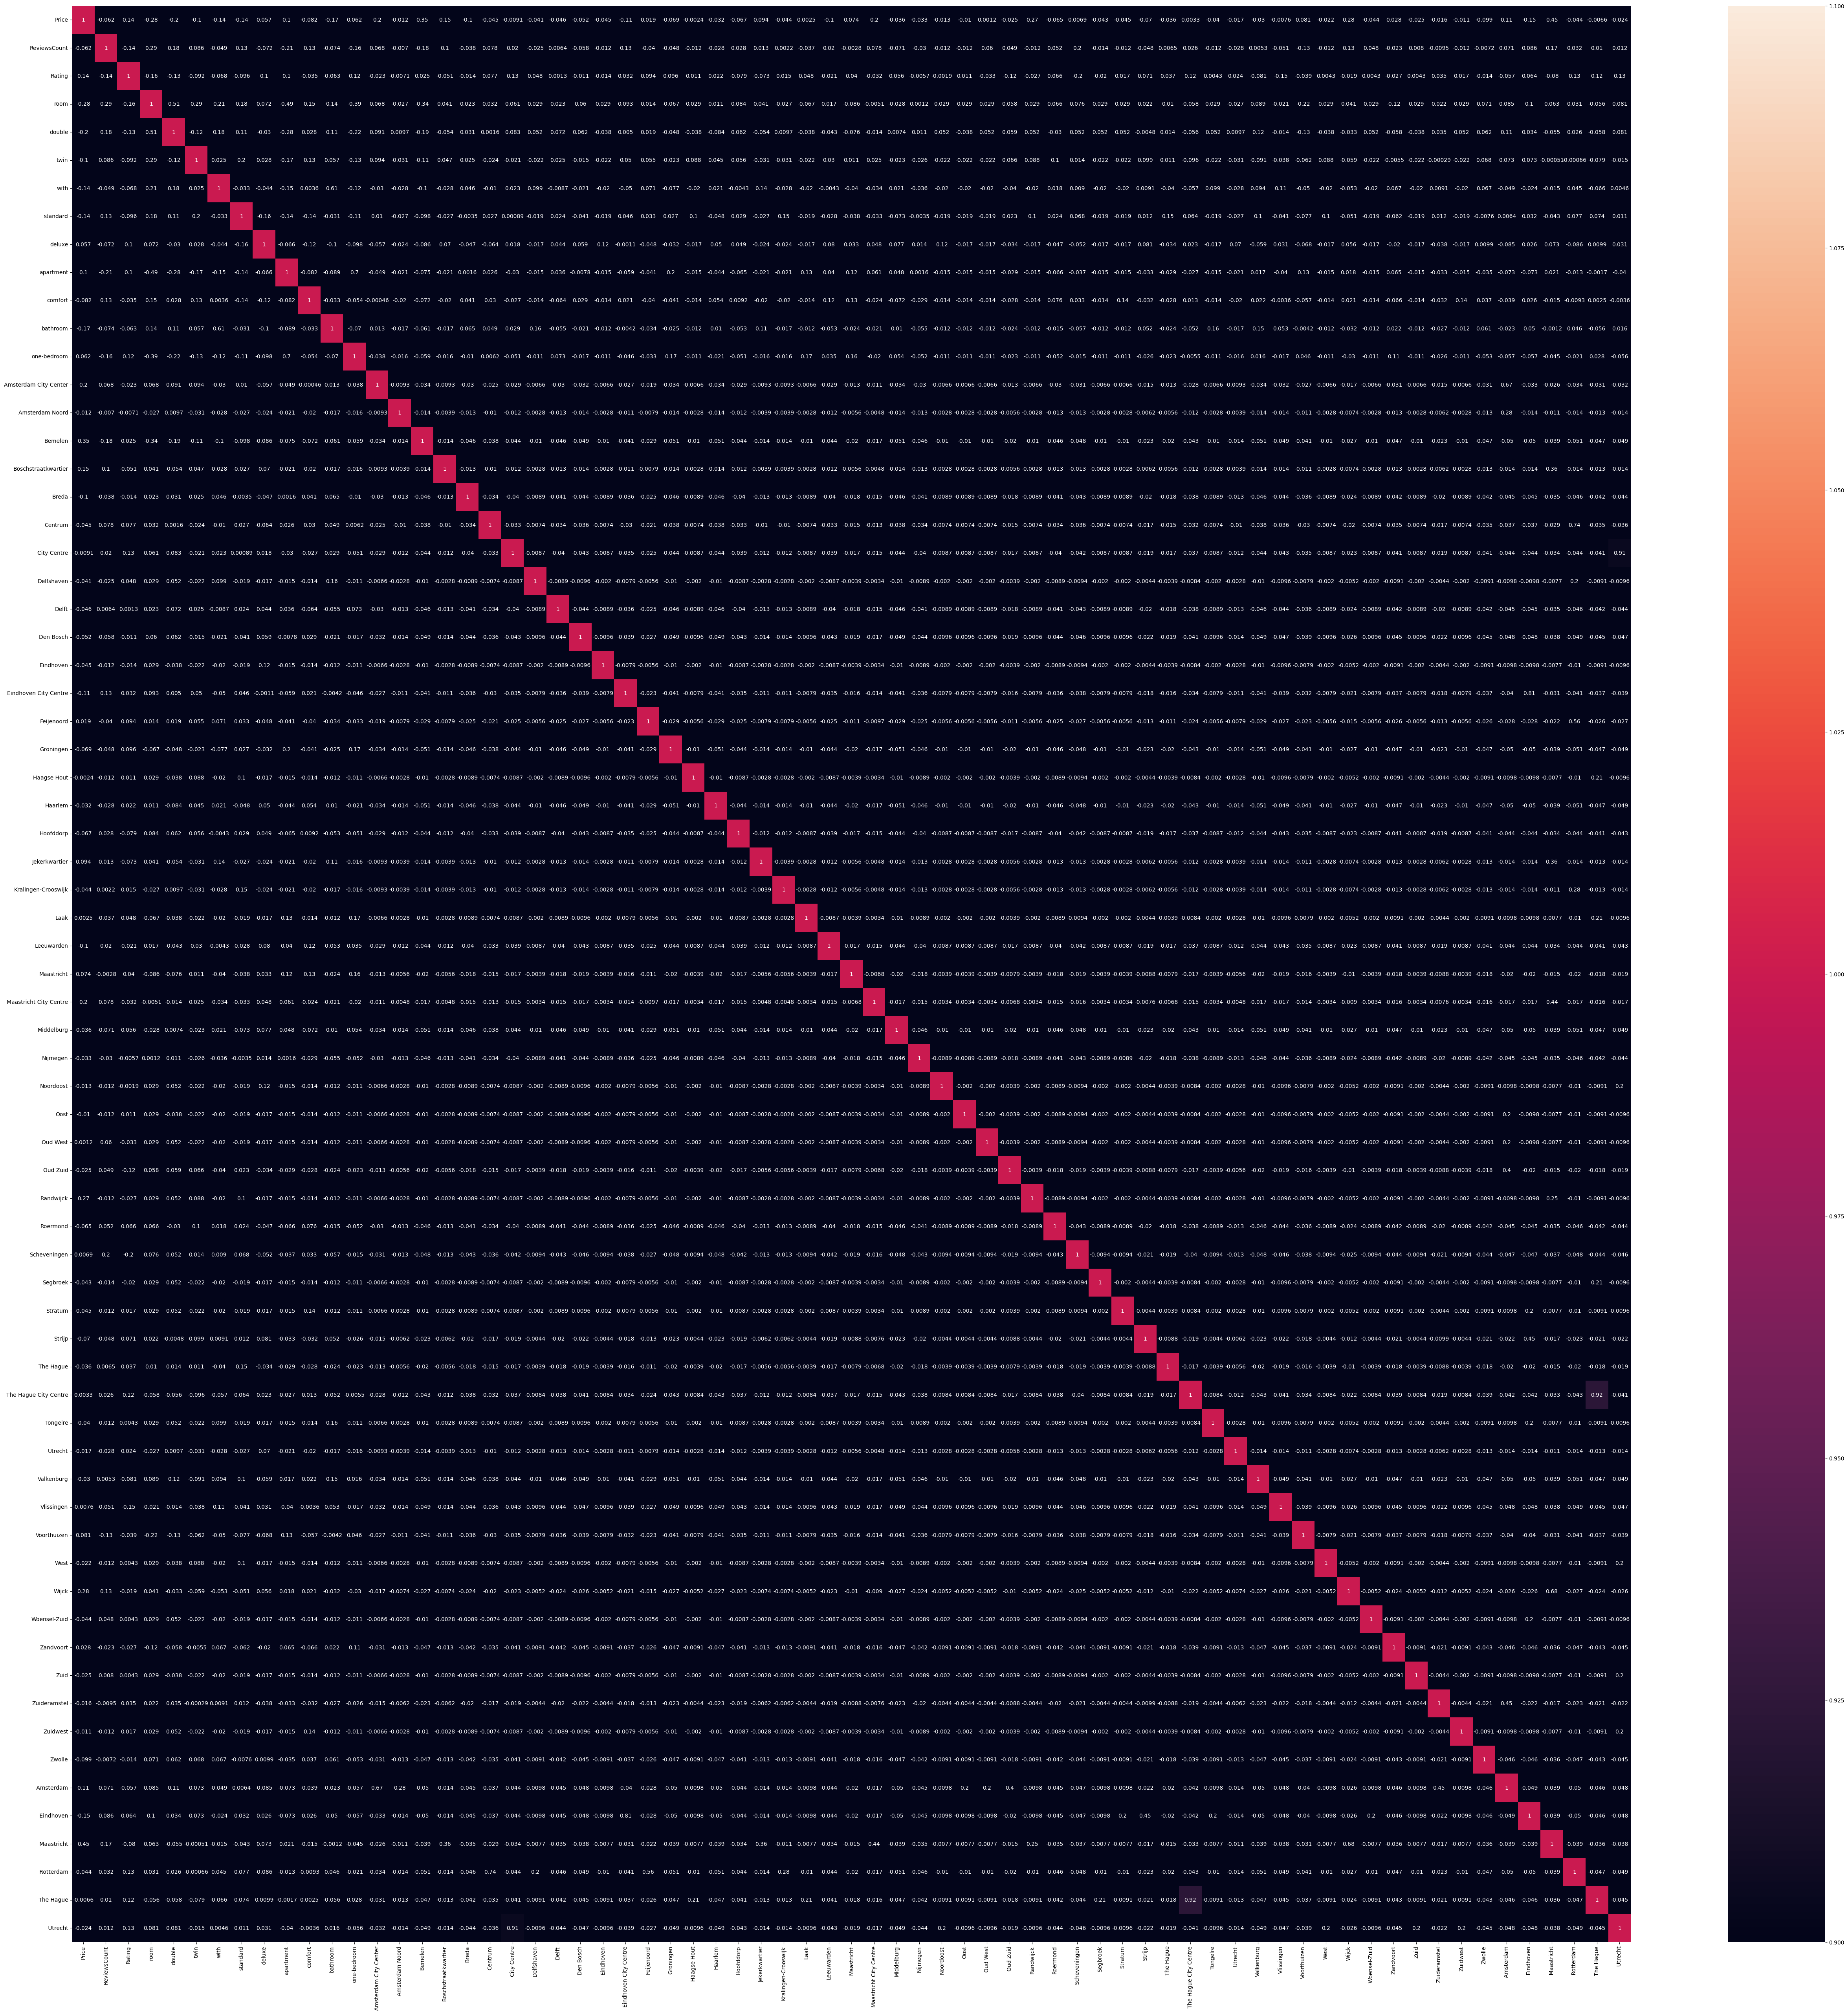

In [33]:
# We can create a heatmap to visualise correlations

plt.figure(figsize=(64, 64))
sns.heatmap(df.corr(), vmin=1, vmax=1, annot=True)

In [34]:
df

,Price,ReviewsCount,Rating,room,double,twin,with,standard,deluxe,apartment,...,Zuid,Zuideramstel,Zuidwest,Zwolle,Amsterdam,Eindhoven,Maastricht,Rotterdam,The Hague,Utrecht
0,7.887,778.0,8.4,0,0,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
1,15.267,500.0,8.1,1,1,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
2,13.063,1605.0,7.4,1,1,0,0,0,0,0,...,False,False,False,False,True,False,False,False,False,False
3,12.854,500.0,9.0,1,1,1,1,0,0,0,...,False,True,False,False,True,False,False,False,False,False
4,9.471,500.0,8.8,1,1,0,0,0,0,0,...,False,True,False,False,True,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,8.899,232.0,8.4,0,0,0,0,0,0,1,...,False,False,False,True,False,False,False,False,False,False
521,10.205,1402.0,7.7,1,1,0,0,1,0,0,...,False,False,False,True,False,False,False,False,False,False
522,6.123,149.0,7.2,1,1,0,1,0,0,0,...,False,False,False,True,False,False,False,False,False,False
523,7.789,1095.0,7.2,1,0,1,0,1,0,0,...,False,False,False,True,False,False,False,False,False,False


### Some Statistics

In [35]:
df[['Price', 'ReviewsCount', 'Rating']].describe()

,Price,ReviewsCount,Rating
count,512.000000,512.000000,512.000000
mean,12.812465,736.556641,8.330273
std,6.514815,879.553639,0.713554
min,3.988000,1.000000,3.700000
25%,8.693000,239.000000,8.000000
50%,11.199500,500.000000,8.400000
75%,14.288000,888.000000,8.800000
max,53.439000,7748.000000,10.000000


For example the mean rating is 8.331456. We can see that we have outliers in this 'Price' and 'ReviewsCount' column. We can remove them.

In [36]:
df = pd.DataFrame(np.array([[1, 1], [2, 10], [3, 100], [4, 100]]), columns=['a', 'b'])

In [38]:
df

,a,b
0,1,1
1,2,10
2,3,100
3,4,100


In [37]:
df.quantile(.1)

a    1.3
b    3.7
Name: 0.1, dtype: float64